In [1]:
import torch
from transformers import CLIPModel, CLIPProcessor, CLIPVisionModel, CLIPVisionModelWithProjection
from PIL import Image
import torchvision
from torch.nn import DataParallel
import torchvision.transforms as T
from torchvision.transforms import InterpolationMode
import warnings
import numpy as np

/home/users/mxy/miniconda3/envs/VLM_Poisoning/lib/python3.10/site-packages/bitsandbytes/cextension.py:34: UserWarning: The installed version of bitsandbytes was compiled without GPU support. 8-bit optimizers, 8-bit multiplication, and GPU quantization are unavailable.
  warn("The installed version of bitsandbytes was compiled without GPU support. "


/home/users/mxy/miniconda3/envs/VLM_Poisoning/lib/python3.10/site-packages/bitsandbytes/libbitsandbytes_cpu.so: undefined symbol: cadam32bit_grad_fp32
[2025-01-09 20:24:18,253] [INFO] [real_accelerator.py:110:get_accelerator] Setting ds_accelerator to cuda (auto detect)


In [2]:
warnings.filterwarnings("ignore")
model_name = "openai/clip-vit-large-patch14"
clip_model = CLIPModel.from_pretrained(model_name).eval()
clip_vision_model = CLIPVisionModelWithProjection.from_pretrained("openai/clip-vit-base-patch32")
# clip_vision_model = CLIPVisionModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained(model_name)

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


In [3]:
input_res=clip_vision_model.vision_model.config.image_size

In [4]:
img_path = "../data/mini_MathVista_grid/target/bar.png"

with Image.open(img_path) as img:
    pil_image = img
    img_tensor = torchvision.transforms.PILToTensor()(img.convert('RGB'))

In [5]:
img_tensor.shape

torch.Size([3, 553, 699])

In [6]:
device = clip_vision_model.device

In [7]:
inputs = processor(images=img_tensor, return_tensors="pt")
# processed_img = torch.from_numpy(np.array(processor.image_processor.preprocess(img_tensor)["pixel_values"])).cuda()
inputs = inputs.to(device)

In [8]:
outputs = clip_vision_model(**inputs)

In [9]:
last_hidden_state_tensor = outputs.last_hidden_state

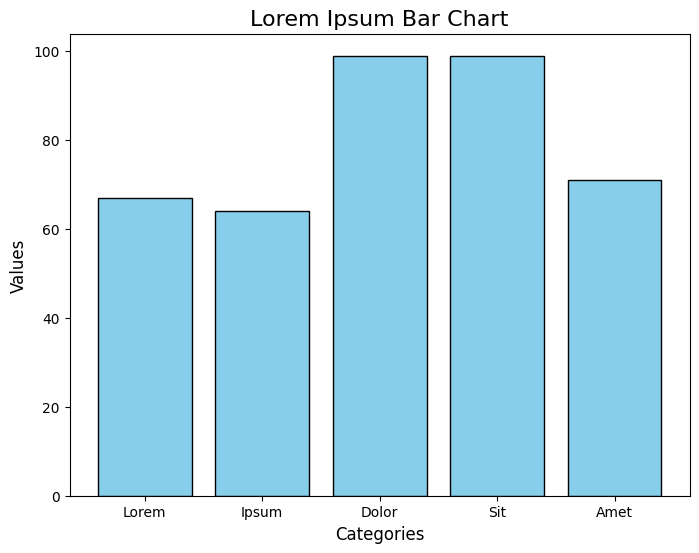

In [10]:
pil_image

In [11]:
pil_inputs = processor(images=pil_image, return_tensors="pt")
pil_outputs = clip_vision_model(**pil_inputs)
last_hidden_state_pil = pil_outputs.last_hidden_state

In [12]:
last_hidden_state_pil == last_hidden_state_tensor

tensor([[[True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         ...,
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True]]])

In [2]:
from clip import MyClip

[2025-01-09 23:15:27,154] [INFO] [real_accelerator.py:110:get_accelerator] Setting ds_accelerator to cuda (auto detect)


In [3]:
model = MyClip()

In [5]:
text_embeds = model.encode_text("hello, my name e jeff")

In [6]:
text_embeds.shape

torch.Size([1, 512])

# AEGE Work

In [1]:
import sys
import os
sys.path.append(os.path.abspath(".."))  # Adjust as needed

from models.CLIP.clip import clip

In [2]:
import torchvision

In [3]:
from PIL import Image

In [4]:
import torch

In [54]:
import numpy as np

In [41]:
device = "cuda"

clip_rn_50,_ = clip.load('RN50', device=device)
clip_rn_101,_ = clip.load('RN101', device=device)
clip_vit_b_16,_ = clip.load('ViT-B/16', device=device)
clip_vit_b_32,_ = clip.load('ViT-B/32', device=device)
clip_vit_l_14,_ = clip.load('ViT-L/14', device=device)
models = [clip_rn_50, clip_rn_101, clip_vit_b_16, clip_vit_b_32, clip_vit_l_14]
# models = [clip_vit_b_32]
clip_preprocess = torchvision.transforms.Compose(
    [
        torchvision.transforms.Resize(clip_vit_b_32.visual.input_resolution, interpolation=torchvision.transforms.InterpolationMode.BICUBIC, antialias=True),
        # torchvision.transforms.Lambda(lambda img: torch.clamp(img, 0.0, 255.0) / 255.0),
        torchvision.transforms.CenterCrop(clip_vit_b_32.visual.input_resolution),
        torchvision.transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711)), # CLIP imgs mean and std.
    ]
)
final_preprocess = torchvision.transforms.Compose(
    [
        torchvision.transforms.Resize(clip_vit_b_32.visual.input_resolution, interpolation=torchvision.transforms.InterpolationMode.BICUBIC, antialias=True),
        # torchvision.transforms.Lambda(lambda img: torch.clamp(img, 0.0, 255.0) / 255.0),
        torchvision.transforms.CenterCrop(clip_vit_b_32.visual.input_resolution),
    ]
)


In [55]:
def to_tensor(pic):
    mode_to_nptype = {"I": np.int32, "I;16": np.int16, "F": np.float32}
    img = torch.from_numpy(np.array(pic, mode_to_nptype.get(pic.mode, np.uint8), copy=True))
    img = img.view(pic.size[1], pic.size[0], len(pic.getbands()))
    img = img.permute((2, 0, 1)).contiguous()
    return img.to(dtype=torch.get_default_dtype())

In [56]:
transform_fn = torchvision.transforms.Compose(
        [
            torchvision.transforms.Resize(224, interpolation=torchvision.transforms.InterpolationMode.BICUBIC),
            torchvision.transforms.CenterCrop(224),
            torchvision.transforms.Lambda(lambda img: img.convert("RGB")),
            torchvision.transforms.Lambda(lambda img: to_tensor(img)),
            torchvision.transforms.Lambda(lambda img: torch.clamp(img, 0.0, 255.0) / 255.0),
        ]
    )
transform_fn_org = torchvision.transforms.Compose(
    [
        torchvision.transforms.Resize(256, interpolation=torchvision.transforms.InterpolationMode.BICUBIC),
        torchvision.transforms.CenterCrop(256),
        torchvision.transforms.ToTensor(), # [0, 1]
        torchvision.transforms.Lambda(lambda img: (img * 2 - 1)),
        # torchvision.transforms.Lambda(lambda img: img.convert("RGB")),
        # torchvision.transforms.Lambda(lambda img: to_tensor(img)),
    ]
)

In [57]:
img_path = "../data/mini_MathVista_grid/target/bar.png"

with Image.open(img_path) as img:
    pil_image = img
    img_tensor = transform_fn(img.convert('RGB'))

In [60]:
# image_tgt = img_tensor.to(torch.float16).to(device)
image_tgt = img_tensor.to(device)

In [62]:
image_tgt = image_tgt.unsqueeze(0)

In [63]:
with torch.no_grad():
    tgt_image_features_list=[]
    image_tgt = clip_preprocess(image_tgt)
    for clip_model in models:
        tgt_image_features = clip_model.encode_image(image_tgt)  # [bs, 512]
        tgt_image_features = tgt_image_features / tgt_image_features.norm(dim=1, keepdim=True)
        tgt_image_features_list.append(tgt_image_features)

In [64]:
for i, feat in enumerate(tgt_image_features_list):
    if torch.all(torch.isnan(feat)):
        print("nothing here man", i)

In [65]:
tgt_image_features_list

[tensor([[ 0.0439, -0.0006, -0.0093,  ...,  0.0137, -0.0059, -0.0108]],
        device='cuda:0', dtype=torch.float16),
 tensor([[-2.6962e-02, -5.5847e-02, -4.1779e-02, -4.4975e-03,  5.0659e-02,
          -4.9652e-02, -2.4872e-02, -4.3854e-02, -7.5569e-03,  2.3804e-02,
          -7.4097e-02, -2.6810e-02,  3.6964e-03, -9.6069e-02, -8.5754e-02,
          -6.7444e-02,  6.9275e-02,  2.3071e-02,  1.1101e-02, -2.1500e-02,
           1.6434e-02, -5.8502e-02,  2.2202e-02, -5.7373e-02,  5.2917e-02,
           2.6825e-02, -2.1095e-03,  2.3834e-02,  1.8478e-02,  4.6509e-02,
           6.1035e-03,  3.0075e-02, -4.7882e-02, -1.2665e-02, -4.4342e-02,
           2.1820e-02,  8.4839e-03,  5.6114e-03,  2.4811e-02,  9.9060e-02,
          -3.2410e-02,  1.0132e-02,  7.3433e-03,  5.8075e-02, -3.2166e-02,
          -4.5807e-02,  1.0170e-02,  5.6091e-02,  3.6621e-02,  5.1483e-02,
          -3.9246e-02,  3.7041e-03,  2.2156e-02,  2.0126e-02,  1.5472e-02,
          -6.0577e-03,  1.3016e-02, -8.2550e-03, -1.5869

In [ ]:
import torchvision
from PIL import Image
import torch
import numpy as np

import sys
import os
sys.path.append(os.path.abspath(".."))  # Adjust as needed

from models.CLIP.clip import clip

# models = [clip_vit_b_32]
clip_preprocess = torchvision.transforms.Compose(
    [
        torchvision.transforms.Resize(clip_vit_b_32.visual.input_resolution, interpolation=torchvision.transforms.InterpolationMode.BICUBIC, antialias=True),
        # torchvision.transforms.Lambda(lambda img: torch.clamp(img, 0.0, 255.0) / 255.0),
        torchvision.transforms.CenterCrop(clip_vit_b_32.visual.input_resolution),
        torchvision.transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711)), # CLIP imgs mean and std.
    ]
)
final_preprocess = torchvision.transforms.Compose(
    [
        torchvision.transforms.Resize(clip_vit_b_32.visual.input_resolution, interpolation=torchvision.transforms.InterpolationMode.BICUBIC, antialias=True),
        # torchvision.transforms.Lambda(lambda img: torch.clamp(img, 0.0, 255.0) / 255.0),
        torchvision.transforms.CenterCrop(clip_vit_b_32.visual.input_resolution),
    ]
)

class MyClipEnsemble():
    def __init__(self):
        warnings.filterwarnings("ignore")
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        clip_rn_50,_ = clip.load('RN50', device=device)
        clip_rn_101,_ = clip.load('RN101', device=device)
        clip_vit_b_16,_ = clip.load('ViT-B/16', device=device)
        clip_vit_b_32,_ = clip.load('ViT-B/32', device=device)
        clip_vit_l_14,_ = clip.load('ViT-L/14', device=device)
        self.models = [clip_rn_50, clip_rn_101, clip_vit_b_16, clip_vit_b_32, clip_vit_l_14]

        self.clip_preprocess = torchvision.transforms.Compose(
            [
                torchvision.transforms.Resize(clip_vit_b_32.visual.input_resolution, interpolation=torchvision.transforms.InterpolationMode.BICUBIC, antialias=True),
                # torchvision.transforms.Lambda(lambda img: torch.clamp(img, 0.0, 255.0) / 255.0),
                torchvision.transforms.CenterCrop(clip_vit_b_32.visual.input_resolution),
                torchvision.transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711)), # CLIP imgs mean and std.
            ]
        )
        
    def encode_image(self, image, use_grad=True):
        tgt_image_features_list = []
        image_tgt = clip_preprocess(image)

        context = torch.enable_grad() if use_grad else torch.no_grad()
        with context:
            for clip_model in models:
                tgt_image_features = clip_model.encode_image(image_tgt)  # [bs, 512]
                tgt_image_features /= tgt_image_features.norm(dim=1, keepdim=True)
                tgt_image_features_list.append(tgt_image_features)

        return tgt_image_features_list
    
    def get_loss(self, adv_image_features_list, tgt_image_features_list):
        loss = torch.zeros(1).to(device)
        crit_list = []
        for model_i, (pred_i, target_i) in enumerate(zip(adv_image_feature_list, tgt_image_features_list)):
            crit1 =  torch.mean(torch.sum(pred_i * target_i, dim=1))  # 有目标攻击
            # crit2 = 1 - torch.mean(torch.sum(pred_i * org_i, dim=1)) # 无目标攻击
            costs[i-idx_time, model_i] = crit1.data
            loss.add_(crit1, alpha=weights[i-idx_time, model_i])
            crit_list.append(crit1.data.detach().cpu().numpy())
            # loss.add_(crit2, alpha=0.3)    
        # print("loss:", crit_list)
        gradient = torch.autograd.grad(loss, img_n)[0]
        gradient = torch.clamp(gradient, min=-0.0025, max=0.0025)  # 0.0025


nothing here man 0
nothing here man 1


In [ ]:
class MyClipEnsemble():
    def __init__(self):
        warnings.filterwarnings("ignore")
        model_name = "openai/clip-vit-base-patch32"
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        self.clip_vision_model = CLIPVisionModelWithProjection.from_pretrained(model_name).to(self.device)
        self.clip_text_model = CLIPTextModelWithProjection.from_pretrained(model_name).to(self.device)
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        
        self.input_res = self.clip_vision_model.vision_model.config.image_size

    def encode_image(self, image, use_grad=True):
        outputs = self.clip_vision_model(pixel_values=clip_preprocess(image))
        return outputs.image_embeds

    def encode_text(self, text):
        inputs = self.tokenizer(text, padding=True, return_tensors="pt")
        inputs.to(self.device)
        outputs = self.clip_text_model(**inputs)
        return outputs.text_embeds